In [1]:
import sys,os,time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.ndimage
from skimage.io import imread, imsave
from skimage.transform import rotate

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from utils import LARGE_CHIP_SIZE, CHIP_SIZE, NUM_WORKERS,MixedLoss, joint_transform, mixed_loss
from tqdm import tqdm

from dataloader import AirbusShipPatchDataset, AirbusShipDataset
from streaming_dataloader import StreamingShipDataset, StreamingShipValTestDataset
import joblib

import rasterio
import fiona
import shapely.geometry
import cv2
import rasterio.features

import segmentation_models_pytorch as smp

In [2]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'
CLASSES=1
BATCH_SIZE=1

loss = MixedLoss(10.0,2.0)
loss.__name__ = "MixedLoss"

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

device = torch.device("cuda:%d" % 0)

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    activation=ACTIVATION,
    classes=CLASSES
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

#  Test Loader

streaming_test_dataset = StreamingShipValTestDataset("./data/test_df.csv", "./data/train_v2/", 
    large_chip_size=LARGE_CHIP_SIZE, chip_size=CHIP_SIZE, transform=joint_transform, preprocessing_fn=preprocessing_fn,
    rotation_augmentation=False, only_ships=True)

streaming_test_aug_dataset = StreamingShipValTestDataset("./data/test_df.csv", "./data/train_v2/", 
    large_chip_size=LARGE_CHIP_SIZE, chip_size=CHIP_SIZE, transform=joint_transform, preprocessing_fn=preprocessing_fn,
    rotation_augmentation=True, only_ships=True)

test_loader = DataLoader(dataset=streaming_test_dataset, batch_size = 8, num_workers=4)

test_aug_loader = DataLoader(dataset=streaming_test_aug_dataset, batch_size = 8, num_workers=4)


In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [15]:
non_aug_model = torch.load('./best_model_non_aug.pth')
non_aug_model = non_aug_model.to(device)

aug_model = torch.load('./best_model_aug.pth')
aug_model = aug_model.to(device)

In [5]:
non_aug_model_max = torch.load('./non_aug_models/model_non_aug_9.pth')
non_aug_model_max = non_aug_model_max.to(device)

aug_model_max = torch.load('./aug_models/model_aug_9.pth')
aug_model_max = aug_model_max.to(device)

In [16]:
test_epoch_aug_Unet = smp.utils.train.ValidEpoch(
    aug_model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

test_epoch_non_aug_Unet = smp.utils.train.ValidEpoch(
    non_aug_model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

running tests:

test_aug_loader,
test_loader


findings: max doesn't seem to perform as well :O

In [17]:
# Aug model, aug dataset
test_epoch_aug_Unet.run(test_aug_loader)

valid: 50960it [09:03, 93.83it/s, MixedLoss - 10.64, iou_score - 0.5153] 


{'MixedLoss': 10.640408594347287, 'iou_score': 0.5152689688919561}

In [8]:
# Aug model, non aug dataset
test_epoch_aug_Unet.run(test_loader)

valid: 6370it [03:24, 31.12it/s, MixedLoss - 9.598, iou_score - 0.3234]


{'MixedLoss': 9.598068728327181, 'iou_score': 0.3234343617358451}

In [9]:
# Non aug model, non aug dataset
test_epoch_non_aug_Unet.run(test_loader)

valid: 6370it [03:25, 31.05it/s, MixedLoss - 9.459, iou_score - 0.3566]


{'MixedLoss': 9.458819473070458, 'iou_score': 0.3566382692236716}

In [10]:
# Non aug model, aug dataset
test_epoch_non_aug_Unet.run(test_aug_loader)

valid: 6370it [04:08, 25.63it/s, MixedLoss - 9.479, iou_score - 0.3454]


{'MixedLoss': 9.479455318368629, 'iou_score': 0.34543162798709554}

# Test

tensor(-1.7066) tensor(-0.0098)
tensor(-0.0098) tensor(-1.7066)
tensor(0., dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


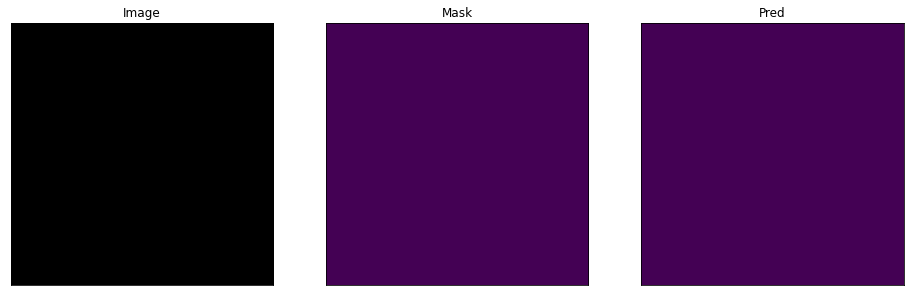

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-2.0306) tensor(-0.4747)
tensor(-0.4747) tensor(-2.0306)
tensor(0., dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


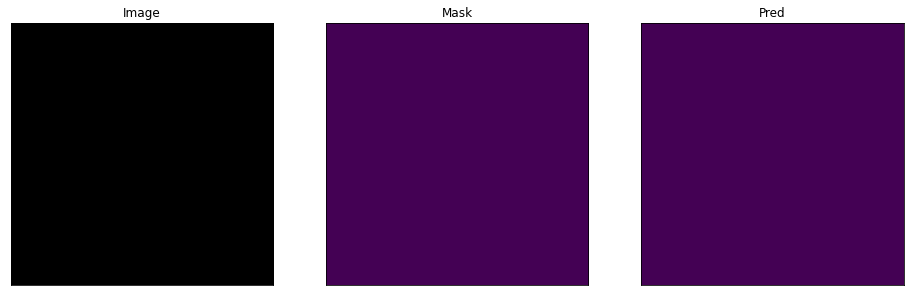

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-2.1179) tensor(1.7479)
tensor(1.7479) tensor(-2.1179)
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


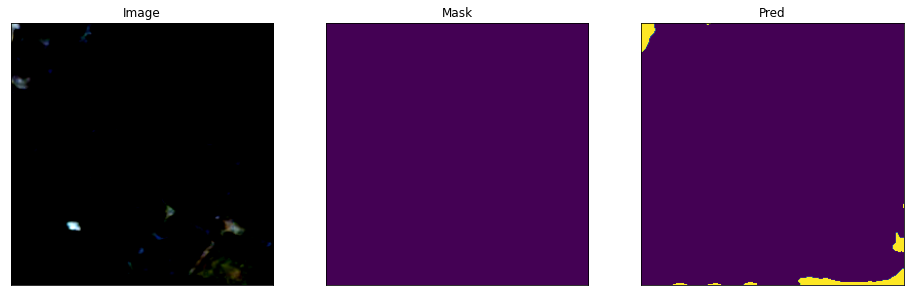

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.6645) tensor(-0.0101)
tensor(-0.0101) tensor(-1.6645)
tensor(0., dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


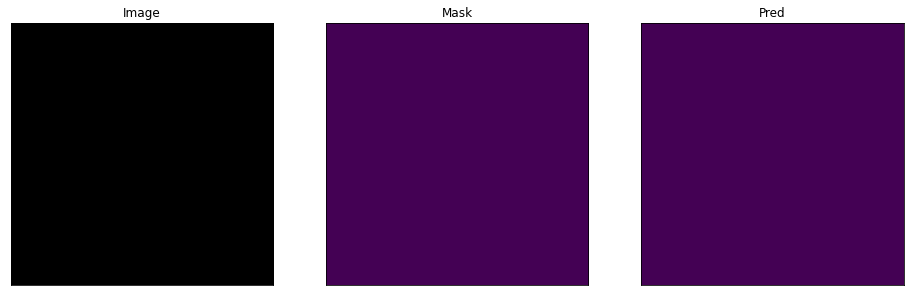

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.6589) tensor(0.0058)
tensor(0.0058) tensor(-1.6589)
tensor(0., dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


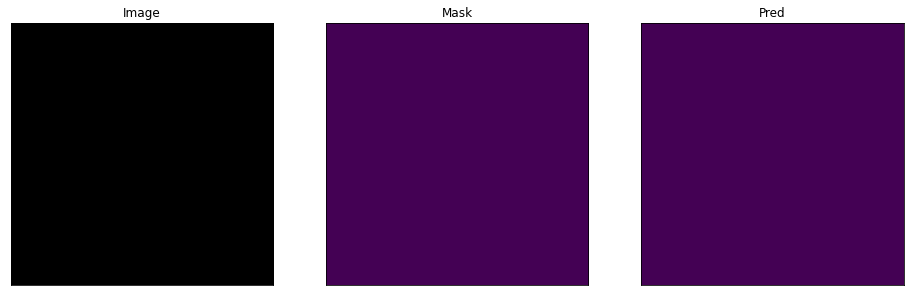

tensor(-2.0111) tensor(-0.4391)
tensor(-0.4391) tensor(-2.0111)
tensor(0., dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


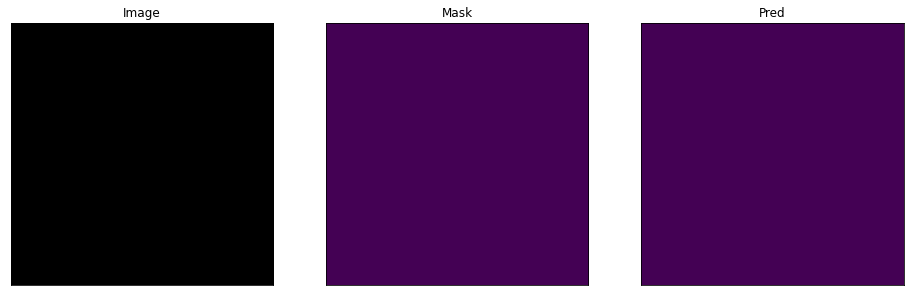

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-2.1172) tensor(1.2123)
tensor(1.2123) tensor(-2.1172)
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


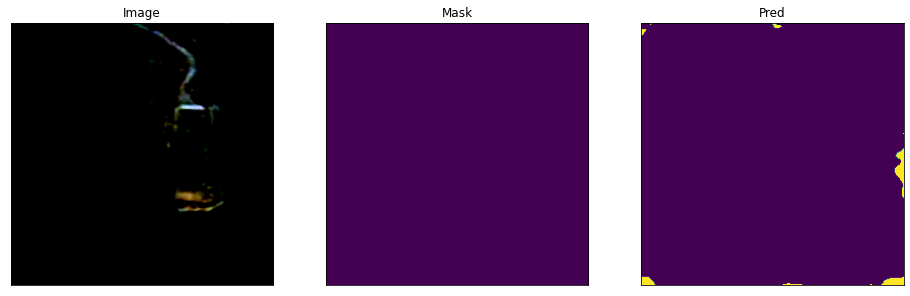

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.7359) tensor(-0.0805)
tensor(-0.0805) tensor(-1.7359)
tensor(0., dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


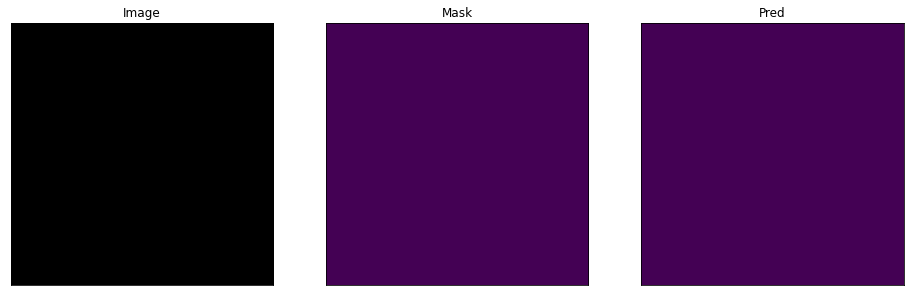

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.5084) tensor(0.0345)
tensor(0.0345) tensor(-1.5084)
tensor(0., dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


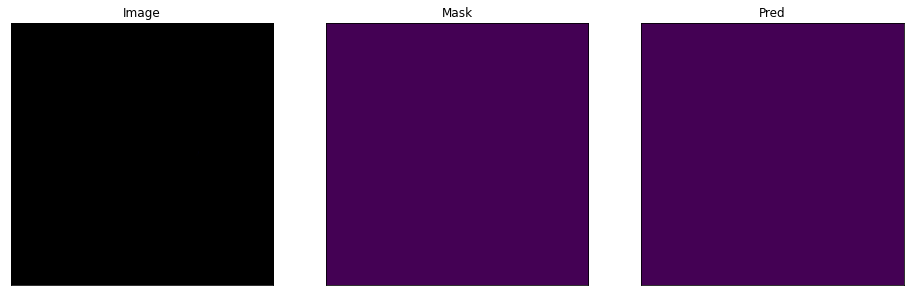

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-2.0323) tensor(-0.4660)
tensor(-0.4660) tensor(-2.0323)
tensor(0., dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


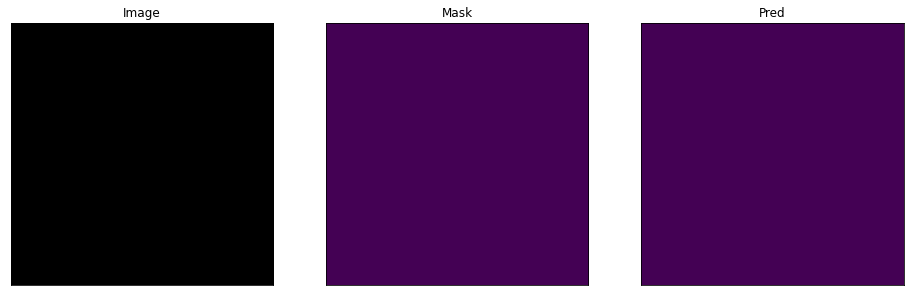

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-2.1175) tensor(1.2114)
tensor(1.2114) tensor(-2.1175)
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


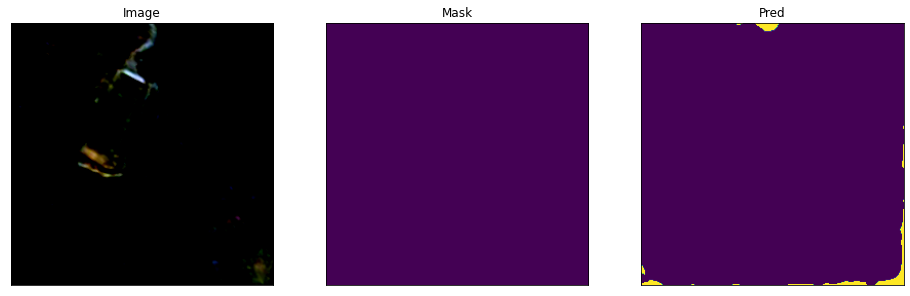

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.7178) tensor(-0.0983)
tensor(-0.0983) tensor(-1.7178)
tensor(0., dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


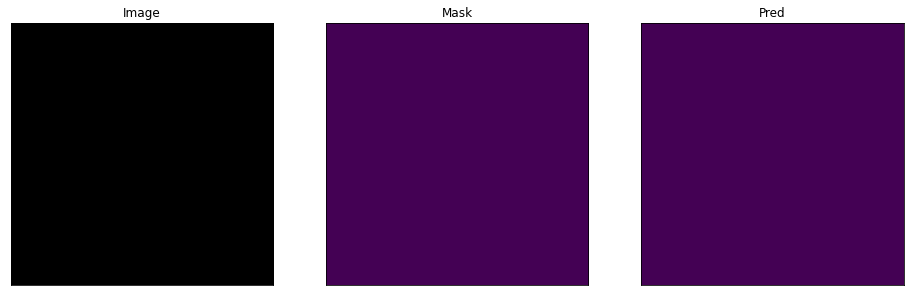

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.7361) tensor(-0.0115)
tensor(-0.0115) tensor(-1.7361)
tensor(0., dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


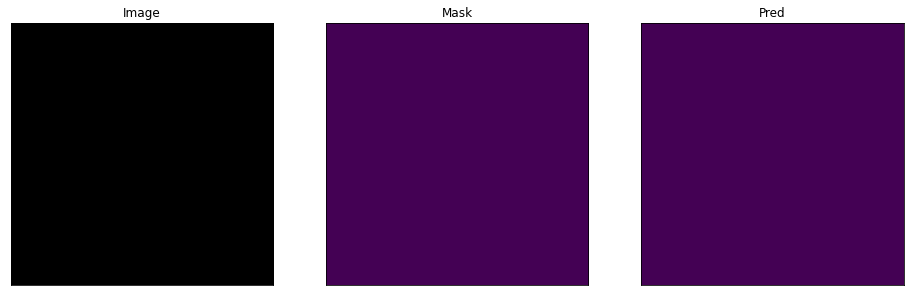

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-2.0468) tensor(-0.4929)
tensor(-0.4929) tensor(-2.0468)
tensor(0., dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


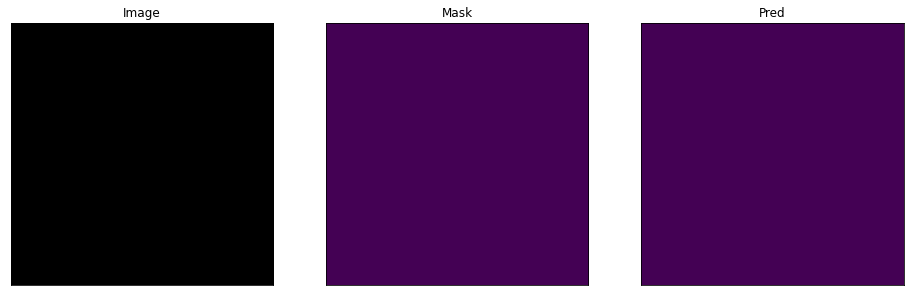

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-2.1172) tensor(1.8999)
tensor(1.8999) tensor(-2.1172)
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


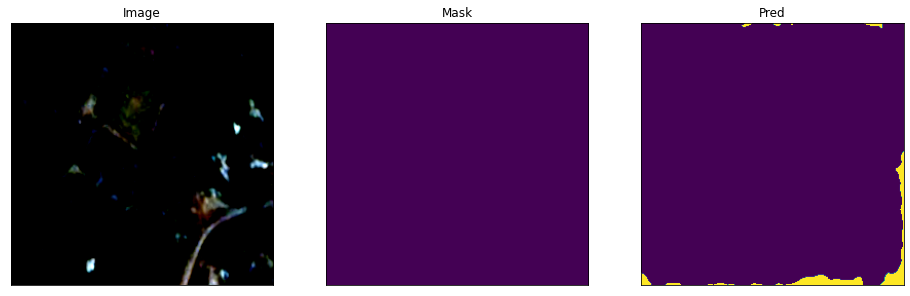

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.6790) tensor(-0.0748)
tensor(-0.0748) tensor(-1.6790)
tensor(0., dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


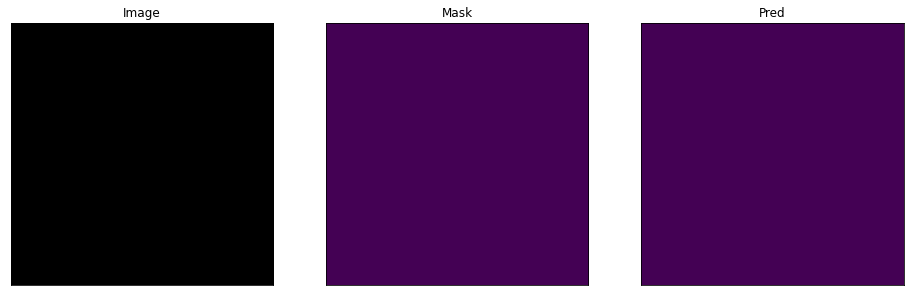

tensor(-1.7379) tensor(-0.0803)
tensor(-0.0803) tensor(-1.7379)
tensor(0., dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


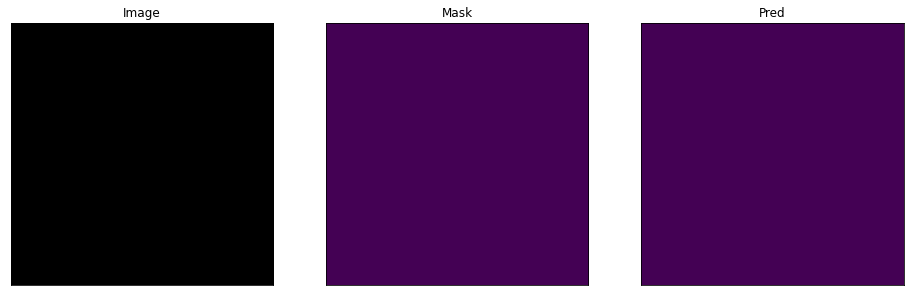

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-2.0416) tensor(-0.4662)
tensor(-0.4662) tensor(-2.0416)
tensor(0., dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


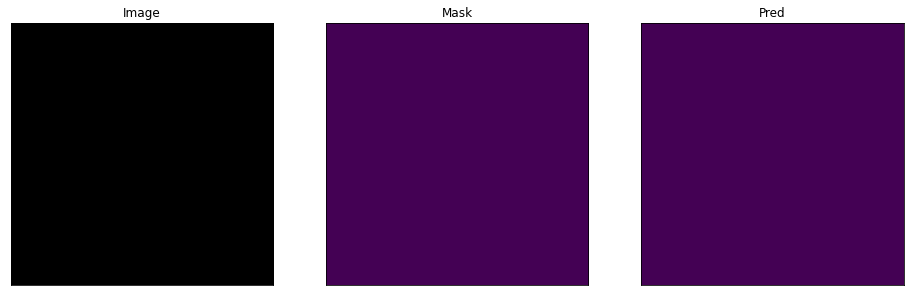

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-2.1179) tensor(2.2925)
tensor(2.2925) tensor(-2.1179)
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


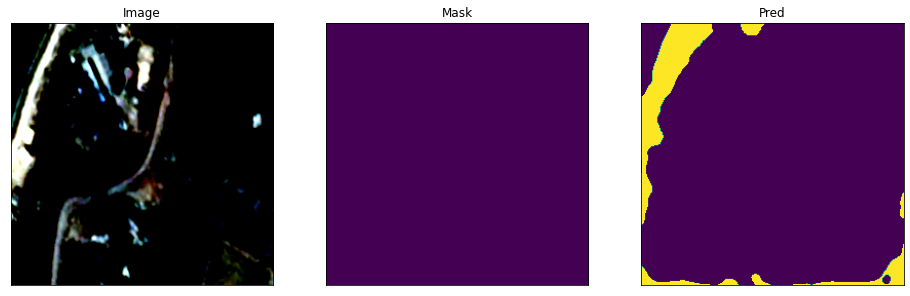

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.6679) tensor(-0.0541)
tensor(-0.0541) tensor(-1.6679)
tensor(0., dtype=torch.float64) tensor(0., dtype=torch.float64)
torch.Size([1, 3, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])


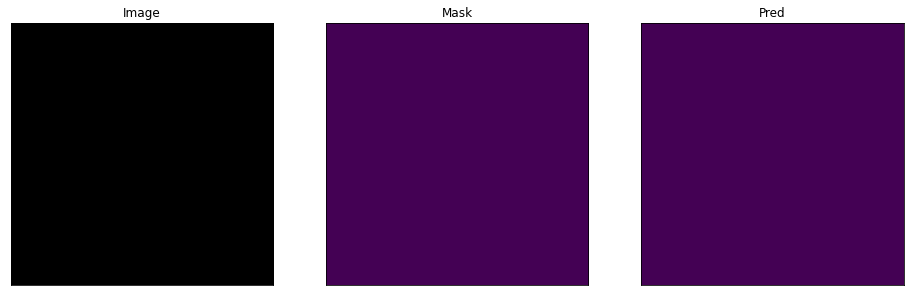

In [18]:
test_aug_loader = DataLoader(dataset=streaming_test_aug_dataset, batch_size = 1, num_workers=4)

examples = iter(test_aug_loader)

for i in range(20):
    
    img,mask = next(examples)
    
    print(img.min(), img.max())
    
    pred = (aug_model(img.cuda()))
    
    pred = pred.detach().cpu().double()
    
    pred[pred >= 0.5] = 1
    
    pred[pred < 0.5] =0
    
    print(img.max(), img.min())

    print(pred.min(), pred.max())
    
    print(img.shape, mask.shape, pred.shape)
    
    visualize(
    image=img.squeeze().permute(1,2,0),
    mask = mask.squeeze(),
    pred = pred.squeeze()
    )